In [3]:
# open eval/cog-plausibility/en/correlation_results.tsv

from pandas import read_csv
import ast
from transformers import AutoTokenizer

remove_objectives = ['min-mean-post-merge', 'frequency-mean-post-merge', 'thresholdBX', 'thresholdM']

def fix_name(tokenizer_name):
    if "bytelevel" in tokenizer_name:
        return "bytelevel_NA_NA_256"
    elif "frequencymulti_" in tokenizer_name:
        return "frequencymulti_BPE_frequencymulti_" + tokenizer_name.split("_")[1]
    elif "frequencymultirussian_" in tokenizer_name:
        return "frequencymultirussian_BPE_frequencymultirussian_" + tokenizer_name.split("_")[1]
    elif "frequency_" in tokenizer_name:
        return "frequency_BPE_frequency_" + tokenizer_name.split("_")[1]
    elif "mutual-information" in tokenizer_name:
        return "mutual-information_NA_mutual-information_" + tokenizer_name.split("_")[1]
    else:
        return tokenizer_name
    
def prepare_df(df):
    df['tokenizer'] = df['tokenizer'].apply(fix_name)
    df['tokenizer'] = df['tokenizer'].apply(lambda x: x.split("_")[0:4])
    df['tokenizer_type'] = df['tokenizer'].apply(lambda x: x[0])
    df['vocab_size'] = df['tokenizer'].apply(lambda x: x[-1])
    df['signal'] = df['tokenizer'].apply(lambda x: x[1])
    df['objective'] = df['tokenizer'].apply(lambda x: x[2])
    df['tokenizer'] = df['tokenizer'].apply(lambda x: '_'.join(x[0:4]))
    df = df[~(df['objective'].isin(remove_objectives))]
    return df

file = "../eval/cog-plausibility/en/NEW_correlation_results.csv"
df = read_csv(file, sep=", ")
df = df.rename(columns={"Tokenizer": "tokenizer"})
df_cog = prepare_df(df)

file = "../tokenizer_stats_fineweb.csv"
df = read_csv(file, sep=",")
df.rename(columns={"tokenizer_name": "tokenizer"}, inplace=True)
df_fert = prepare_df(df)

file = "../tokenizer_stats_common.csv"
df = read_csv(file, sep=",")
df.rename(columns={"tokenizer_name": "tokenizer"}, inplace=True)
df_fert_multi = prepare_df(df)



/tmp/ipykernel_1270372/1359196158.py:35: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = read_csv(file, sep=", ")


In [4]:
t = AutoTokenizer.from_pretrained("InfoTokenizers/tokenizers", subfolder='fw57M_Entropy_thresholdB_32000')
t.tokenize('hello world')

['Ġhe', '##llo', 'Ġworld']

In [13]:
# Plot category=words and measure="NumSplits vs Acc" for vocab_size=8064
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

import seaborn as sns

plt.rcParams['font.serif'] = 'Lato'
plt.rcParams['font.size'] = 22

def plot_correlation(category, measure, vocab_size):
    fig, ax = plt.subplots(figsize=(6, 4))
    df = df_cog[(df_cog['Category'] == category) & (df_cog['vocab_size'] == vocab_size)]
    sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    labels = [x + ' ' + y for x, y in zip(df['tokenizer_type'], df['signal'])]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f"{measure} for {category} with vocab_size={vocab_size}")
    plt.xticks(rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Objective')

    plt.show()

def plot_measure(measure, vocab_size):
    fig, ax = plt.subplots(figsize=(6, 4))
    df = df_fert[(df_fert['vocab_size'] == vocab_size)]
    sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    labels = [x + ' ' + y for x, y in zip(df['tokenizer_type'], df['signal'])]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f"{measure} for {vocab_size}")
    plt.xticks(rotation=45, ha='right')

def plot_measure_multi_single_lang(measure, language):
    fig, ax = plt.subplots(figsize=(6, 6))
    df = df_fert_multi[(df_fert_multi['language'] == language)]
    df = df.sort_values(by='vocab_size', ascending=False)
    sns.lineplot(x='vocab_size', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    ax.set_title(f"{measure} for {language}")
    plt.xticks(rotation=45, ha='right')

def plot_measure_single_vocab(measure, vocab_size, ignore=None):
    fig, ax = plt.subplots(figsize=(9, 4))
    df = df_fert_multi[(df_fert_multi['vocab_size'] == str(vocab_size))]
    # Remove Chinese, Korean and Japanese
    df = df[~df['language'].isin(['Chinese', 'Korean', 'Japanese'])]
    if ignore:
        df = df[~df['tokenizer'].isin(ignore)]
    df = df.sort_values(by='language', ascending=True)
    sns.barplot(x='language', y=measure, data=df, palette="Blues", ax=ax, hue='signal')
    plt.xticks(rotation=90, ha='center')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, title='')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()

def plot_continuation_distribution(tokenizer_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    continuations = df_fert[(df_fert['tokenizer'] == tokenizer_name)]['split_lengths_distribution'].values[0]
    continuations = continuations.replace("defaultdict(<class 'int'>, ","").replace(")","")
    continuations = ast.literal_eval(continuations)
    continuations = {int(k): v for k, v in continuations.items() if k < 20}
    continuations = dict(sorted(continuations.items()))
    x = list(continuations.keys())
    y = list(continuations.values())
    ax.bar(x, y)
    ax.set_xlabel('Continuation Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Continuation Length Distribution for {tokenizer_name}")
    x_ticks = list(range(1, 20))
    ax.set_xticks(x_ticks)
    plt.show()

def get_length_distribution(tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained("InfoTokenizers/tokenizers", subfolder=tokenizer_name)
    vocab = tokenizer.get_vocab()
    lengths = {i : 0 for i in range(1, 20)}
    for token in vocab:
        length = len(token.replace('##', ''))
        if length not in lengths:
            continue
        lengths[length] += 1
    lengths = dict(sorted(lengths.items()))
    return lengths

def plot_grouped_bar_plot(list_of_lengths, names):
    fig, ax = plt.subplots(figsize=(12, 4))
    x = list(range(len(list_of_lengths[0])))
    width = 0.2
    for i, lengths in enumerate(list_of_lengths):
        y = list(lengths.values())
        ax.bar([p + width * i for p in x], y, width=width, label=names[i])
    ax.set_xticks([p + width * (len(list_of_lengths) - 1) / 2 for p in x])
    ax.set_xticklabels(list_of_lengths[0].keys())
    ax.legend()
    plt.show()

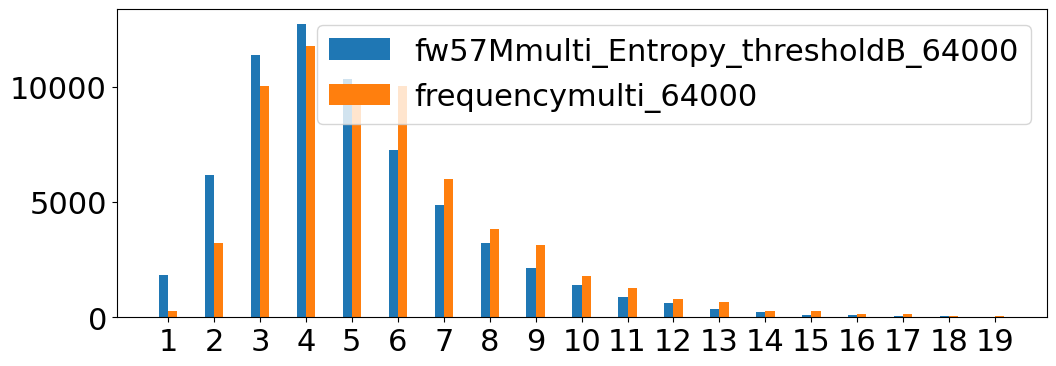

In [14]:
tokenizers = ["fw57Mmulti_Entropy_thresholdB_64000", "frequencymulti_64000"]
lengths = []
for tokenizer in tokenizers:
    lengths.append(get_length_distribution(tokenizer))
plot_grouped_bar_plot(lengths, tokenizers)



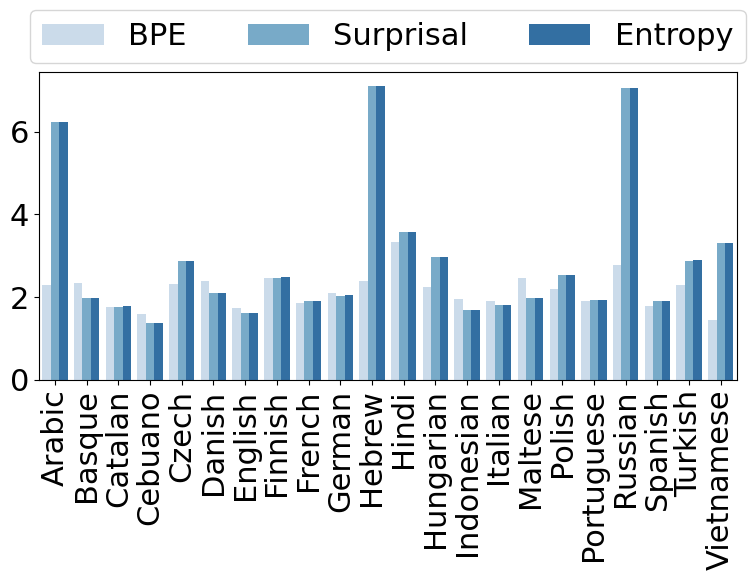

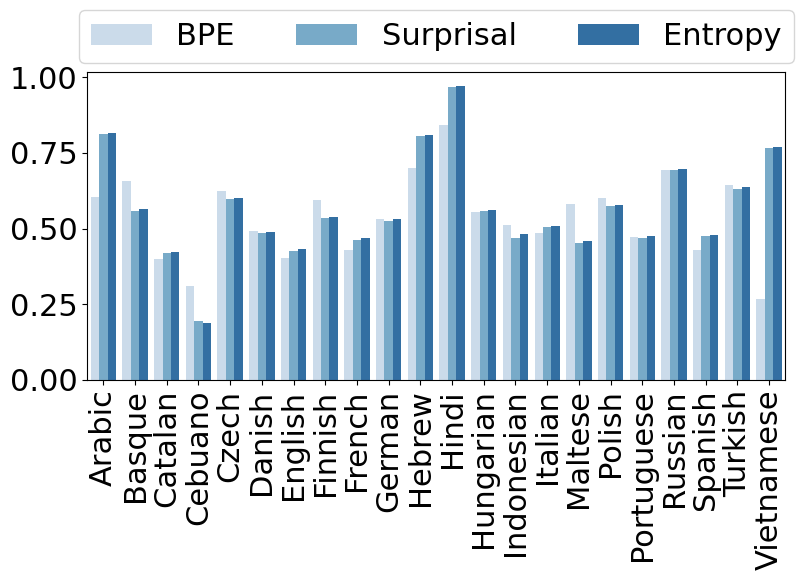

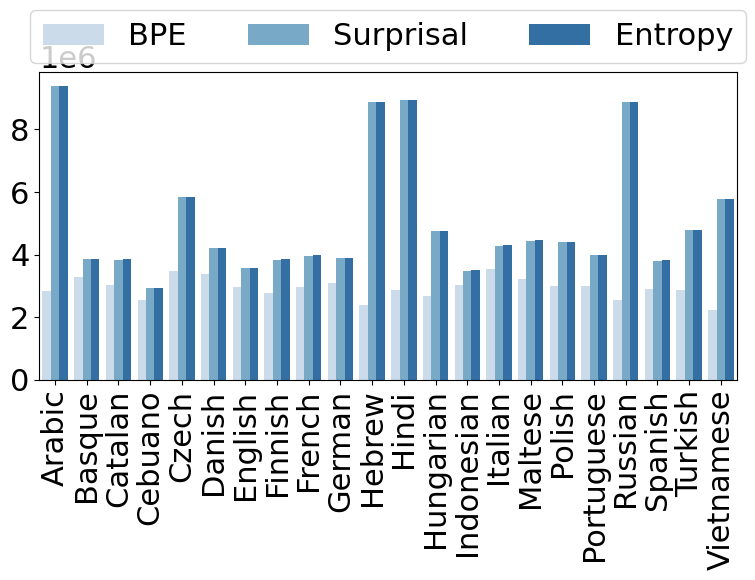

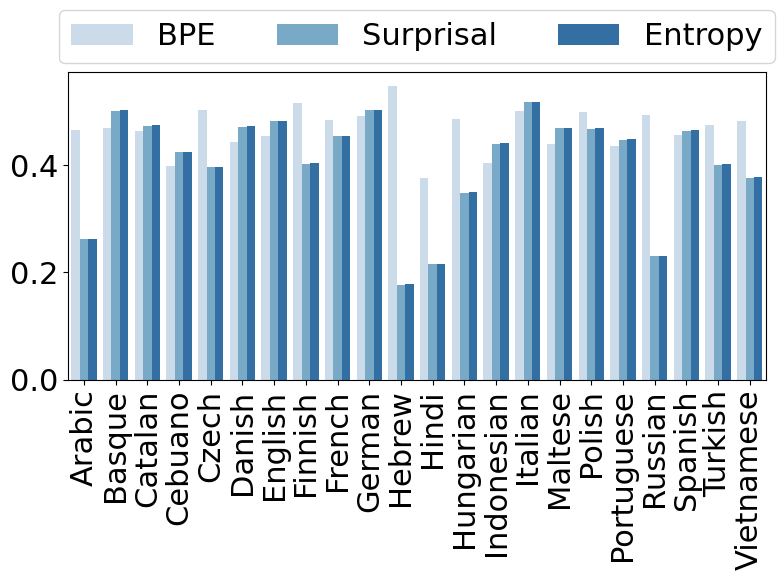

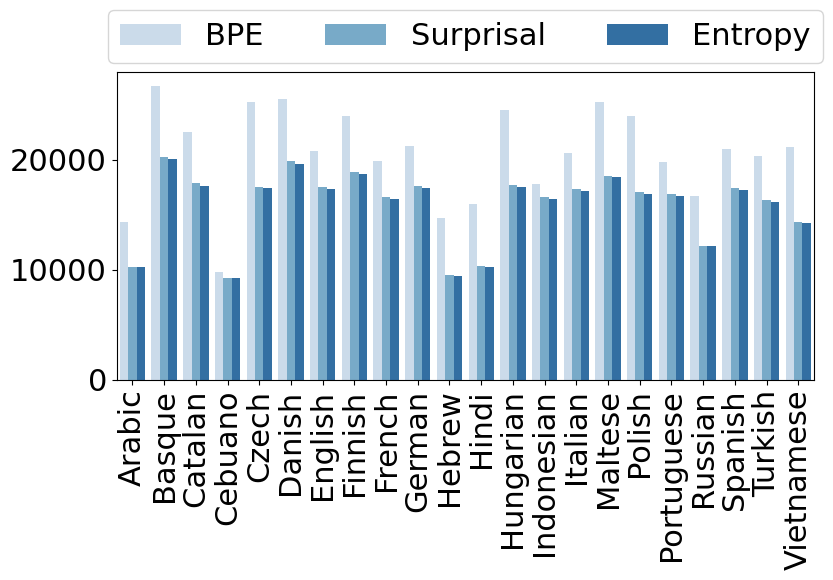

In [15]:
v_size = 64000
ignore = [f'frequencymultirussian_BPE_frequencymultirussian_{v_size}']
plot_measure_single_vocab("fertility", v_size, ignore)
plot_measure_single_vocab("proportion_continued", v_size, ignore)
plot_measure_single_vocab("total_tokens", v_size, ignore)
plot_measure_single_vocab("renyi_efficiency", v_size, ignore)
plot_measure_single_vocab("unique_tokens", v_size, ignore)

# languages = df_fert_multi['language'].unique()
# tmp_df = df_fert_multi[df_fert_multi['vocab_size'] == '64000'].sort_values(by='language')
# # number of languages where tmp_df['fertility'] is bigger for 'objective'=='thresholdB' than 'frquencymulti'
# threshold_scores = tmp_df[tmp_df['objective'] == 'thresholdB']['proportion_continued'].reset_index(drop=True)
# frequency_scores = tmp_df[tmp_df['objective'] == 'frequencymulti']['proportion_continued'].reset_index(drop=True)
# threshold_better = threshold_scores < frequency_scores
# print(f"Number of languages where thresholdB is better than frequencymulti: {threshold_better.sum()}")


In [6]:
text = 'легенде'
text = 'deregionalise'
t = AutoTokenizer.from_pretrained('InfoTokenizers/tokenizers',subfolder='fw57Mmulti_Surprisal_thresholdB_64000')
t = AutoTokenizer.from_pretrained('InfoTokenizers/tokenizers',subfolder='fw57M_Entropy_thresholdB_64000')
print(t.tokenize(text))
t = AutoTokenizer.from_pretrained('InfoTokenizers/tokenizers',subfolder='frequency_64000')
print(t.tokenize(text))

['Ġder', '##egional', '##ise']
['Ġde', 'reg', 'ional', 'ise']


/tmp/ipykernel_1083047/224200705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


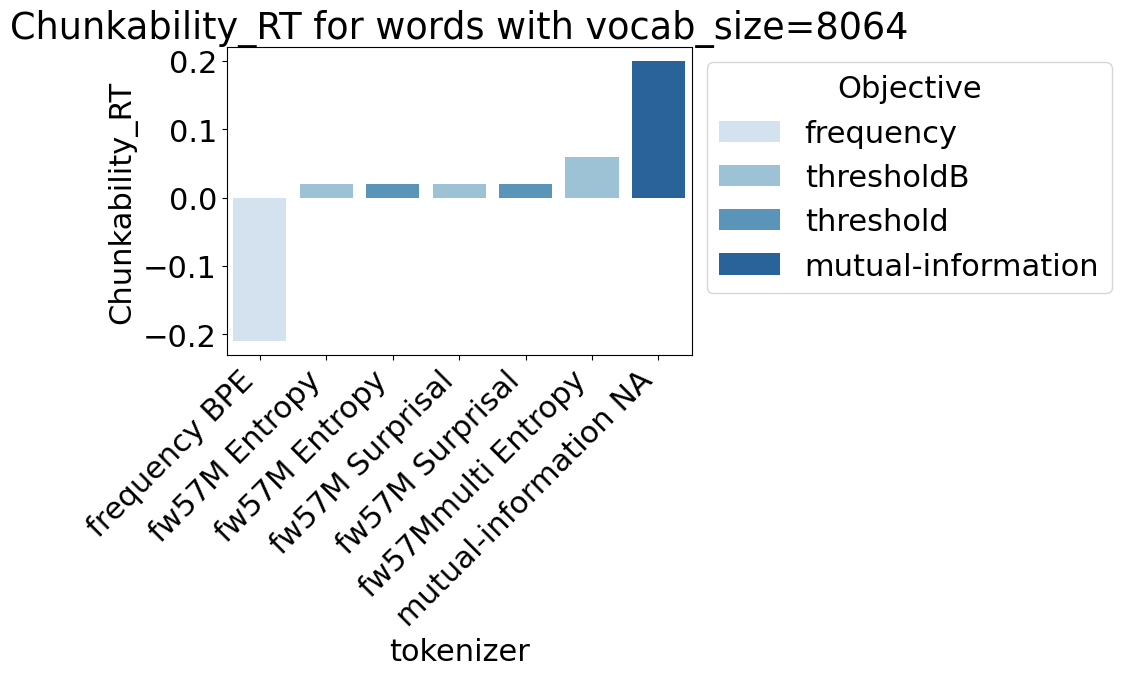

/tmp/ipykernel_1083047/224200705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


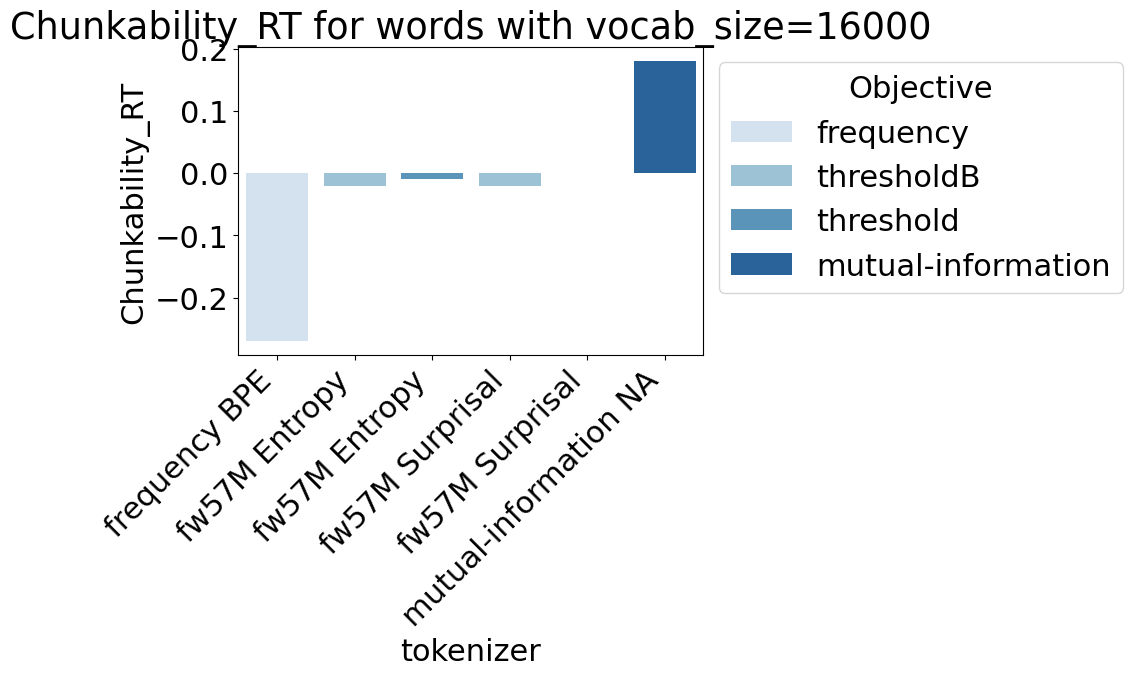

/tmp/ipykernel_1083047/224200705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


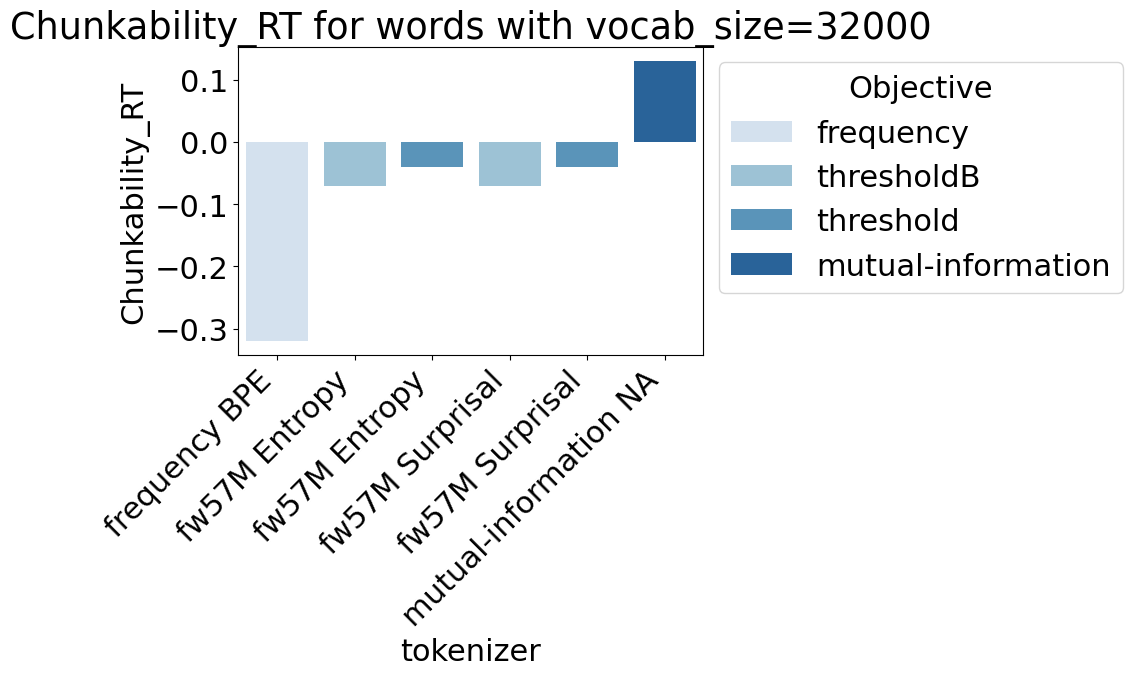

/tmp/ipykernel_1083047/224200705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


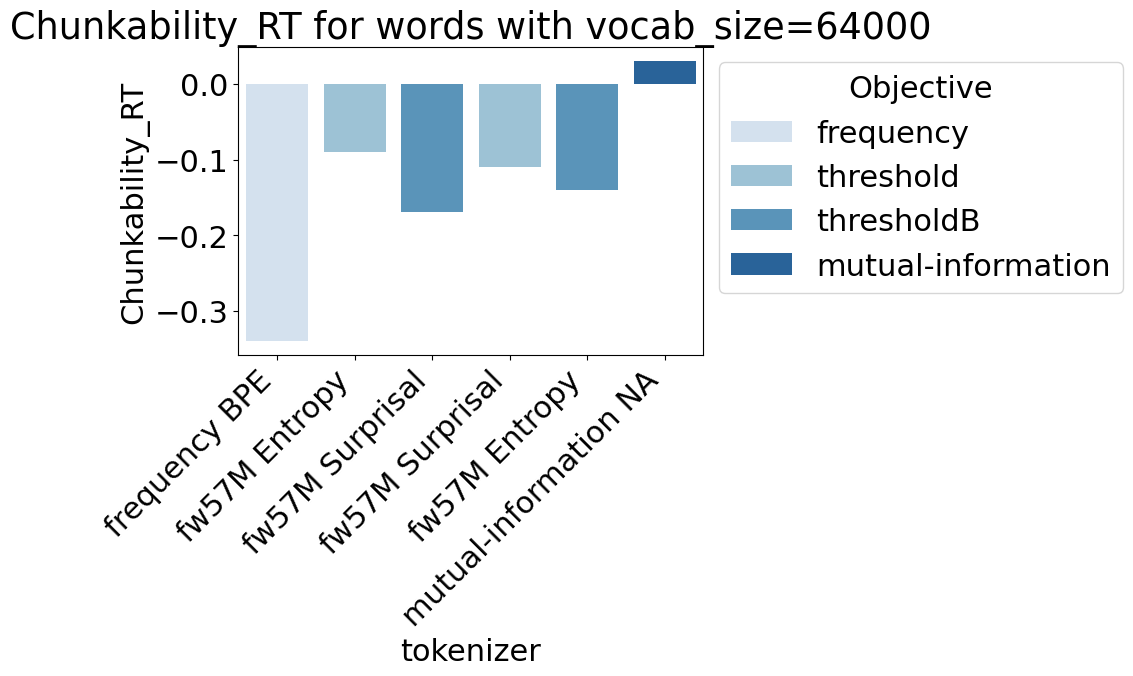

/tmp/ipykernel_1083047/224200705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


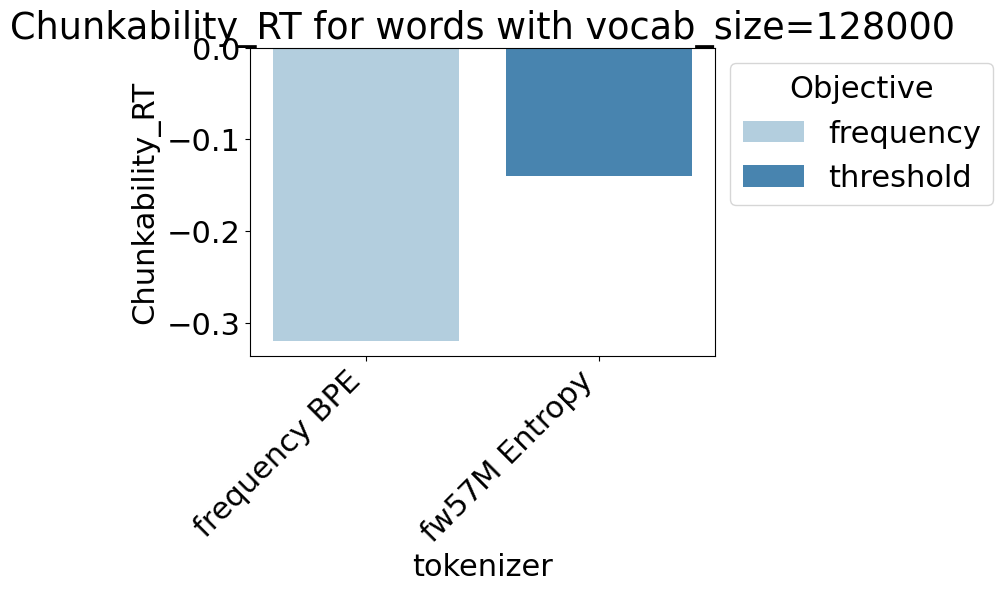

In [7]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_correlation('words', 'Chunkability_RT', vocab_size)

/tmp/ipykernel_1083047/224200705.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


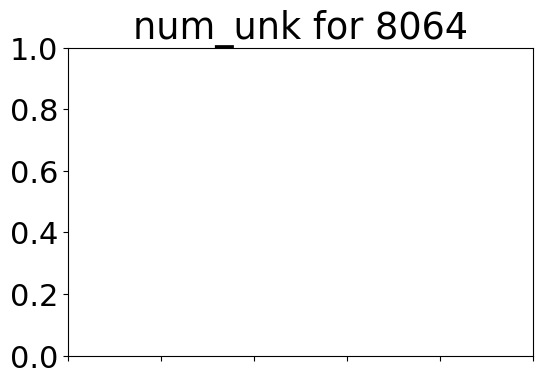

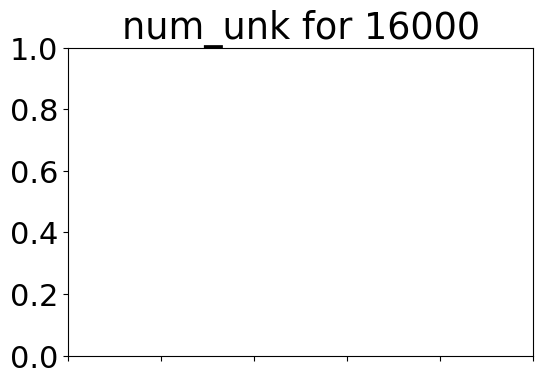

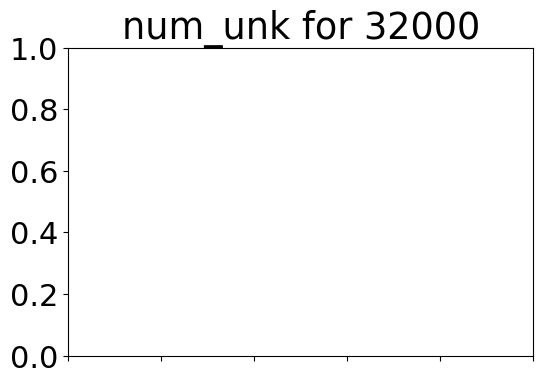

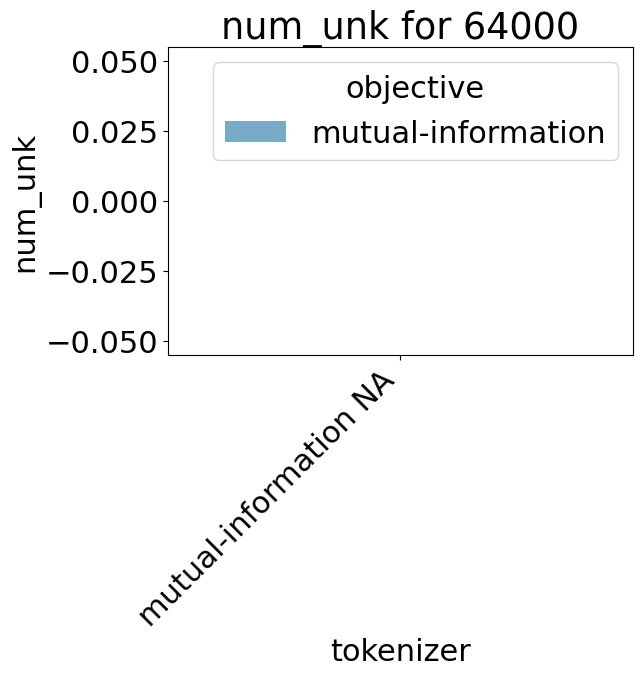

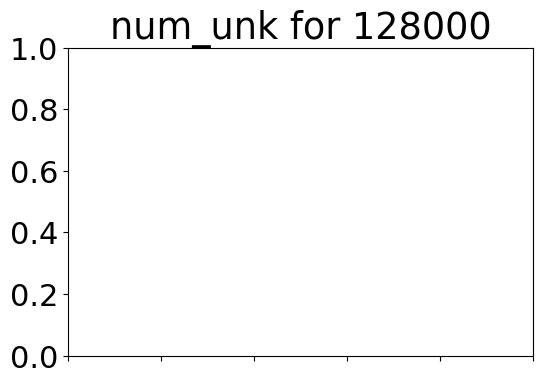

In [8]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('num_unk', vocab_size)

/tmp/ipykernel_1083047/224200705.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


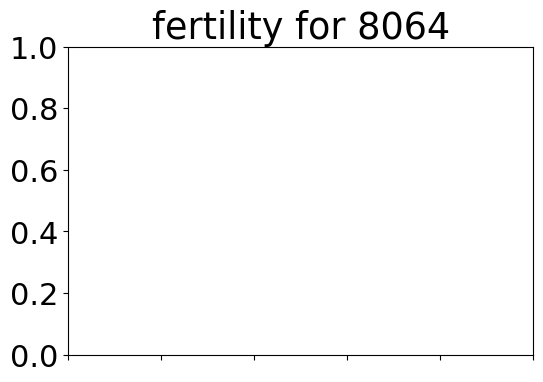

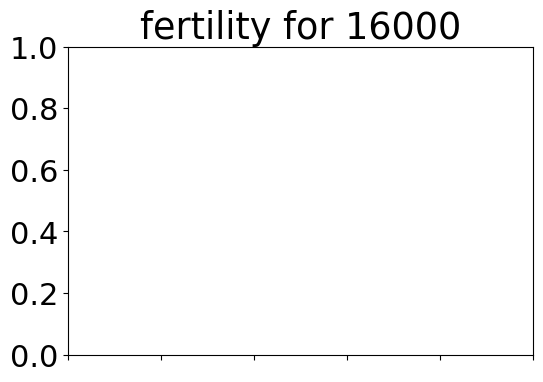

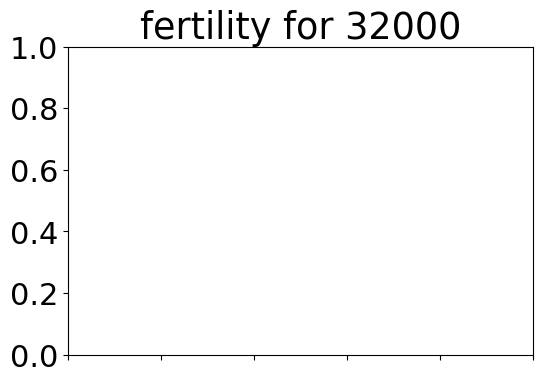

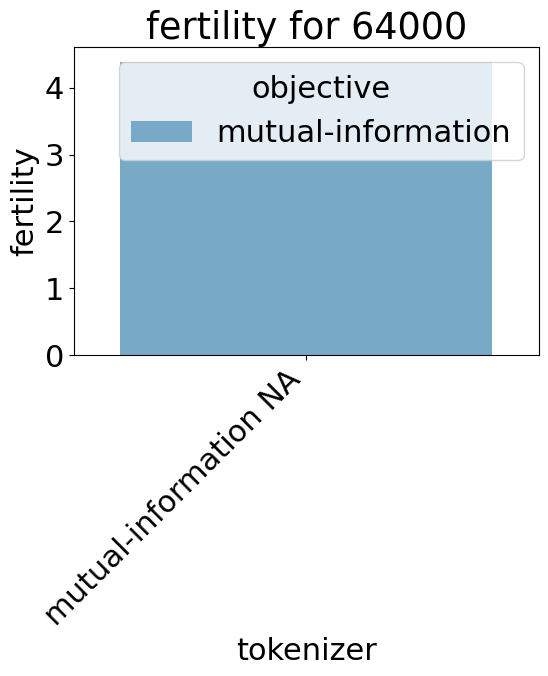

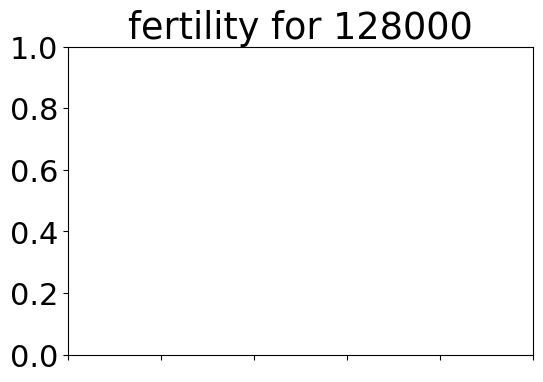

In [9]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('fertility', vocab_size)

/tmp/ipykernel_1083047/224200705.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


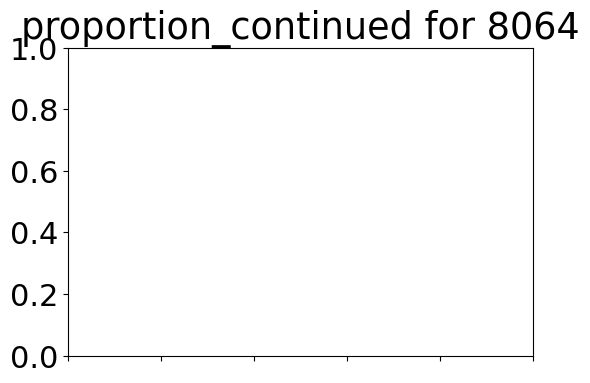

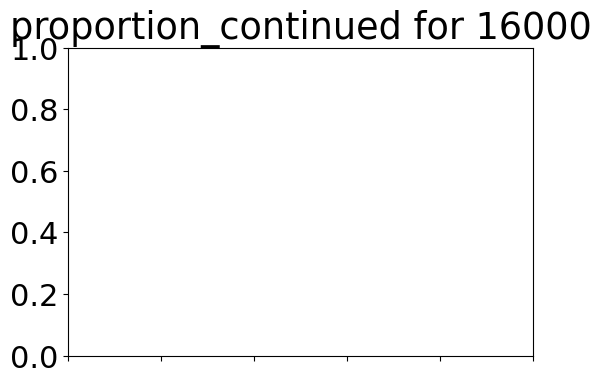

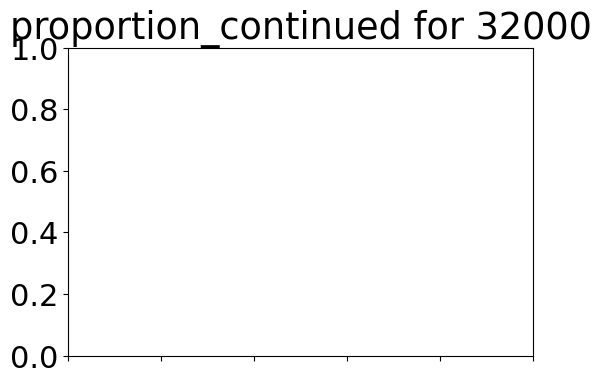

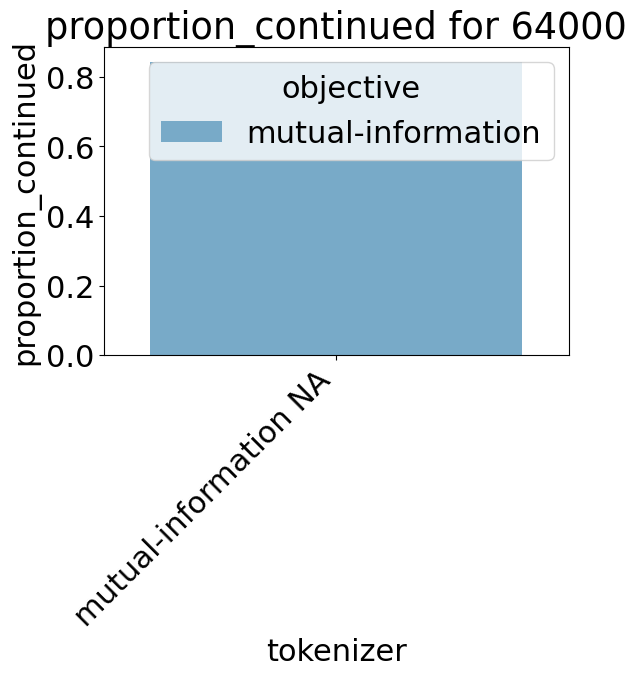

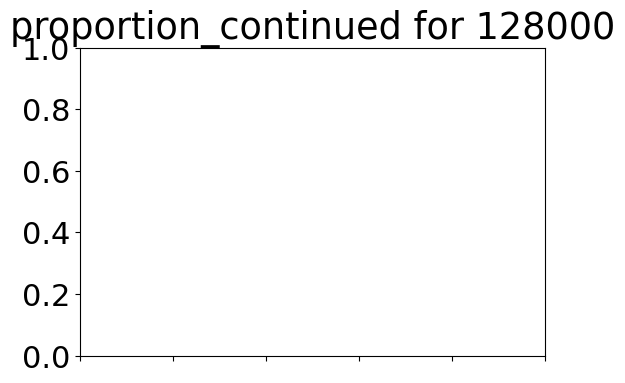

In [10]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('proportion_continued', vocab_size)

In [11]:
df

,tokenizer,language,fertility,proportion_continued,total_split_words,total_words,total_tokens,unique_tokens,num_unk,renyi_efficiency,tokenizer_type,vocab_size,signal,objective
0,fw57Mmulti_Surprisal_thresholdB_16000,English,1.920521,0.556250,1187419,2134685,4231044,6487,7,0.555101,fw57Mmulti,16000,Surprisal,thresholdB
1,fw57Mmulti_Surprisal_thresholdB_16000,Russian,7.138871,0.725445,886256,1221672,8975923,5419,83,0.253965,fw57Mmulti,16000,Surprisal,thresholdB
2,fw57Mmulti_Surprisal_thresholdB_16000,Hungarian,3.251561,0.647523,992913,1533403,5197216,6726,8,0.403035,fw57Mmulti,16000,Surprisal,thresholdB
3,fw57Mmulti_Surprisal_thresholdB_16000,Chinese,5.828063,0.682315,919034,1346935,8300261,5842,544,0.489033,fw57Mmulti,16000,Surprisal,thresholdB
4,fw57Mmulti_Surprisal_thresholdB_16000,Indonesian,2.157852,0.691143,1181390,1709327,4295104,6305,40,0.525011,fw57Mmulti,16000,Surprisal,thresholdB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,fw57Mmulti_Entropy_thresholdB_32000,Italian,1.929420,0.550081,1264074,2297978,4568211,10738,14,0.545506,fw57Mmulti,32000,Entropy,thresholdB
321,fw57Mmulti_Entropy_thresholdB_32000,Polish,2.683884,0.616459,1046132,1697003,4631948,10937,31,0.497161,fw57Mmulti,32000,Entropy,thresholdB
322,fw57Mmulti_Entropy_thresholdB_32000,Portuguese,2.074855,0.538848,990160,1837551,4268620,10291,212,0.481949,fw57Mmulti,32000,Entropy,thresholdB
323,fw57Mmulti_Entropy_thresholdB_32000,Danish,2.242181,0.543520,1024841,1885562,4495216,11927,17,0.507044,fw57Mmulti,32000,Entropy,thresholdB


In [18]:
for v_size in [8064, 16000, 32000, 64000]:

    t1 = AutoTokenizer.from_pretrained('InfoTokenizers/tokenizers',subfolder=f'fw57M_Surprisal_thresholdB_{v_size}')
    t2 = AutoTokenizer.from_pretrained('InfoTokenizers/tokenizers',subfolder=f'fw57M_Entropy_thresholdB_{v_size}')

    # Get vocab overlap
    vocab1 = t1.get_vocab()
    vocab2 = t2.get_vocab()
    overlap = len(set(vocab1.keys()).intersection(set(vocab2.keys())))
    print(f"Percentage of overlap: {overlap / len(vocab1) * 100:.2f}%")

tokenizer.json:   0%|          | 0.00/178k [00:00<?, ?B/s]

Percentage of overlap: 98.67%


tokenizer.json:   0%|          | 0.00/369k [00:00<?, ?B/s]

Percentage of overlap: 98.29%
Percentage of overlap: 96.38%
Percentage of overlap: 87.51%
